In [13]:
# Importamos las librerias que vamos a utilizar
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
#from funciones import *

In [14]:
# Creamos una lista de los campos de búsqueda
campos_busqueda = ['kw', 'au', 'mc-itype', 'ti', 'an', 'itype', 'su', 'BC', 'bc', 'callnum', 
    'I-format', 'AU', 'an', 'se', 'In', 'bx', 'se', 'su-to', 'mc-itype,phr', 'l-format', 'Provider']

# Creamos una expresión regular para encontrar los campos
patrones = r'\b(?:' + '|'.join(campos_busqueda) + r')\b'

# Funcion para extraer el campo de cada fila
def extraer_campo(texto):
    """
    Extrae un campo específico de un texto dado utilizando una expresión regular.
    Args:
        texto (str): El texto del cual se desea extraer el campo.
    Returns:
        str or None: El campo extraído si se encuentra una coincidencia, de lo contrario, None.
    """
    match = re.search(patrones, texto)
    return match.group(0) if match else None

#--------------------------------------------------------------------------------------------------------------------------------------
# Funcion para extraer la sintaxis de cada fila
def extraer_sintaxis(texto):
    """
    Extrae la sintaxis de cada búsqueda de los usuarios que contienen ':' o '='.
    Args:
        texto (str): El texto de la búsqueda.
    Returns:
        str: La sintaxis extraída.
    """
    sintaxis = re.findall(r'[:=]\s*([^,]+)', texto)
    return ', '.join(sintaxis)

#--------------------------------------------------------------------------------------------------------------------------------------
# Lista de campos que necesitan un número
campos_necesitan_numero = ['an', 'bc', 'callnum']

# Función para verificar si el campo necesita un número y el usuario ingresó un string
def verificar_error_campo(row):
    if len(row['sintaxis']) == 0 or row['sintaxis'] == ' ' or row['sintaxis'] == None:
        return 'usuario no ingreso nada'
    elif row['campo_utilizado'] in campos_necesitan_numero and not row['sintaxis'].isdigit():
        return 'campo incorrecto'
    return ''

In [15]:
# Abrimos el archivo 'Estadisticas consultas catálogo-reportresults.csv' que contiene los datos de la busqueda de los usuarios en el sistema Koha
data_frame = pd.read_csv("d:/Users/Laura/Desktop/Espacio Integrador II/3 - Practica Academica/Practica-Acad-mica/1 - archivos/Estadísticas consultas catálogo-reportresults.csv", sep=';')

### Identificación de las variables más importantes
##### Se identificarán las variables que ayudarán a resolver nuestro problema

In [16]:
# Filtramos el data frame, nos quedaremos con las variables que resolverán nuestros objetivos
df_filtrado = data_frame[['sessionid', 'query_desc', 'total', 'time', 'categorycode']]

# Mostramos las primeras filas del data frame filtrado
df_filtrado.head()

,sessionid,query_desc,total,time,categorycode
0,8b973f78de404b6eb6548e4a229cb725,"au,wrdl: bronzino",16,2018-10-17 15:27:49,DOCENTE
1,8b973f78de404b6eb6548e4a229cb725,"au,wrdl: bronzino",16,2018-10-17 15:28:25,DOCENTE
2,8b973f78de404b6eb6548e4a229cb725,"au,wrdl: webster",10,2018-10-17 15:29:51,DOCENTE
3,8b973f78de404b6eb6548e4a229cb725,"au,wrdl: webster",10,2018-10-17 15:30:02,DOCENTE
4,8b973f78de404b6eb6548e4a229cb725,"au,wrdl: webster",10,2018-10-17 15:30:13,DOCENTE


### Etapa de limpieza

In [17]:
# Borramos valores duplicados en el data frame filtrado
df_filtrado.drop_duplicates()

print("Cantidad de filas duplicadas eliminadas:", len(df_filtrado) - len(df_filtrado.drop_duplicates()))
print(f"Representando un {((len(df_filtrado) - len(df_filtrado.drop_duplicates())) / len(df_filtrado)) * 100:.2f}% del total de filas")

Cantidad de filas duplicadas eliminadas: 65
Representando un 2.56% del total de filas


In [18]:
# Nos fijamos si las columnas tienen algún valor nulo
df_filtrado.info()

# Podemos observar que de las 2535 filas ninguna posee valores nulos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2535 entries, 0 to 2534
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   sessionid     2535 non-null   object
 1   query_desc    2535 non-null   object
 2   total         2535 non-null   int64 
 3   time          2535 non-null   object
 4   categorycode  2535 non-null   object
dtypes: int64(1), object(4)
memory usage: 99.2+ KB


In [19]:
# Guardamos el DataFrame filtrado en un archivo CSV, para poder explorarlo en otros archivos
df_filtrado.to_csv('1 - archivos/df_filtrado.csv', index=False)

### Preparación de los datos para el análisis estadístico

In [20]:
# Buscamos las búsquedas que no tienen un campo ingresado
filas_sin_query = df_filtrado[~ df_filtrado['query_desc'].str.contains(patrones, na=False)]

In [21]:
# Imputamos las filas que no tienen campos ingresados
filas_sin_query.loc[filas_sin_query.index == 750, 'query_desc'] = filas_sin_query.loc[750, 'query_desc'].replace('robot', 'kw: robot')
filas_sin_query.loc[filas_sin_query.index == 752, 'query_desc'] = filas_sin_query.loc[752, 'query_desc'].replace('robot', 'kw: robot')
filas_sin_query.loc[filas_sin_query.index == 754, 'query_desc'] = filas_sin_query.loc[754, 'query_desc'].replace('da vinci', 'kw,wrdl: da vinci')
filas_sin_query.loc[filas_sin_query.index == 756, 'query_desc'] = filas_sin_query.loc[756, 'query_desc'].replace('robotica', 'kw: robotica')

In [22]:
# Actualizamos los valores de los campos de busqueda en el data frame principal
df_filtrado.update(filas_sin_query)

In [23]:
# Aplicar la función para crear una nueva columna 'campos_utilzado'
df_filtrado.loc[:, 'campo_utilizado'] = df_filtrado['query_desc'].apply(extraer_campo)

C:\Users\Laura\AppData\Local\Temp\ipykernel_12228\1394677314.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado.loc[:, 'campo_utilizado'] = df_filtrado['query_desc'].apply(extraer_campo)


##### Pero como no se guardan todos los campos que utilizo el usuario, tendremos que realizar otra imputacion para estos casos


In [24]:
# Buscamos las filas que tienen más de un : en la búsqueda. Esto nos indica que el usuario ingresó más de un campo de búsqueda
df_filtrado['contador'] = df_filtrado['query_desc'].str.count(':')

# Filtramos las filas que tienen más de un : en la búsqueda
dos_puntos = df_filtrado[df_filtrado['contador'] > 1]

# Borramos la columna 'contador' ya que no es necesaria
df_filtrado.drop('contador', axis=1, inplace=True)

In [25]:
# Imputación de los campos utilizados por los usuarios para hacer la busqueda
df_filtrado.loc[5, 'campo_utilizado'] = (df_filtrado.loc[5, 'campo_utilizado'] + ', su-to')
df_filtrado.loc[6, 'campo_utilizado'] = (df_filtrado.loc[6, 'campo_utilizado'] + ', su-to' + ', su-to')
df_filtrado.loc[7, 'campo_utilizado'] = (df_filtrado.loc[7, 'campo_utilizado'] + ', su-to' + ', su-to' + ', su-to')
df_filtrado.loc[8, 'campo_utilizado'] = (df_filtrado.loc[8, 'campo_utilizado'] + ', su-to' + ', su-to')
df_filtrado.loc[9, 'campo_utilizado'] = (df_filtrado.loc[9, 'campo_utilizado'] + ', su-to')
df_filtrado.loc[10, 'campo_utilizado'] = (df_filtrado.loc[10, 'campo_utilizado'] + ', su-to' + ', su-to')
df_filtrado.loc[11, 'campo_utilizado'] = (df_filtrado.loc[11, 'campo_utilizado'] + ', su-to')
df_filtrado.loc[29, 'campo_utilizado'] = (df_filtrado.loc[29, 'campo_utilizado'] + ', su-to')
df_filtrado.loc[33, 'campo_utilizado'] = (df_filtrado.loc[33, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[35, 'campo_utilizado'] = (df_filtrado.loc[35, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[48, 'campo_utilizado'] = (df_filtrado.loc[48, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[49, 'campo_utilizado'] = (df_filtrado.loc[49, 'campo_utilizado'] + ', mc-itype' + ', mc-itype')
df_filtrado.loc[111, 'campo_utilizado'] = (df_filtrado.loc[111, 'campo_utilizado'] + ', au')
df_filtrado.loc[252, 'campo_utilizado'] = (df_filtrado.loc[252, 'campo_utilizado'] + ', l-format')
df_filtrado.loc[256, 'campo_utilizado'] = (df_filtrado.loc[256, 'campo_utilizado'] + ', l-format')
df_filtrado.loc[277, 'campo_utilizado'] = (df_filtrado.loc[277, 'campo_utilizado'] + ', su-to')
df_filtrado.loc[288, 'campo_utilizado'] = (df_filtrado.loc[288, 'campo_utilizado'] + ', au')
df_filtrado.loc[358, 'campo_utilizado'] = (df_filtrado.loc[358, 'campo_utilizado'] + ', ti'+ ', not au')
df_filtrado.loc[368, 'campo_utilizado'] = (df_filtrado.loc[368, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[374, 'campo_utilizado'] = (df_filtrado.loc[374, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[395, 'campo_utilizado'] = (df_filtrado.loc[395, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[397, 'campo_utilizado'] = (df_filtrado.loc[397, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[429, 'campo_utilizado'] = (df_filtrado.loc[429, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[431, 'campo_utilizado'] = (df_filtrado.loc[431, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[432, 'campo_utilizado'] = (df_filtrado.loc[432, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[444, 'campo_utilizado'] = (df_filtrado.loc[444, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[453, 'campo_utilizado'] = (df_filtrado.loc[453, 'campo_utilizado'] + ', su')
df_filtrado.loc[628, 'campo_utilizado'] = (df_filtrado.loc[628, 'campo_utilizado'] + ', au')
df_filtrado.loc[636, 'campo_utilizado'] = (df_filtrado.loc[636, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[637, 'campo_utilizado'] = (df_filtrado.loc[637, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[649, 'campo_utilizado'] = (df_filtrado.loc[649, 'campo_utilizado'] + ', au')
df_filtrado.loc[746, 'campo_utilizado'] = (df_filtrado.loc[746, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[747, 'campo_utilizado'] = (df_filtrado.loc[747, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[749, 'campo_utilizado'] = (df_filtrado.loc[749, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[768, 'campo_utilizado'] = (df_filtrado.loc[768, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[773, 'campo_utilizado'] = (df_filtrado.loc[773, 'campo_utilizado'] + ', su-to')
df_filtrado.loc[774, 'campo_utilizado'] = (df_filtrado.loc[774, 'campo_utilizado'] + ', se')
df_filtrado.loc[775, 'campo_utilizado'] = (df_filtrado.loc[775, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[776, 'campo_utilizado'] = (df_filtrado.loc[776, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[779, 'campo_utilizado'] = (df_filtrado.loc[779, 'campo_utilizado'] + ', au')
df_filtrado.loc[780, 'campo_utilizado'] = (df_filtrado.loc[780, 'campo_utilizado'] + ', au')
df_filtrado.loc[862, 'campo_utilizado'] = (df_filtrado.loc[862, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[868, 'campo_utilizado'] = (df_filtrado.loc[868, 'campo_utilizado'] + ', su-to')
df_filtrado.loc[869, 'campo_utilizado'] = (df_filtrado.loc[869, 'campo_utilizado'] + ', su-to')
df_filtrado.loc[884, 'campo_utilizado'] = (df_filtrado.loc[884, 'campo_utilizado'] + ', su-to')
df_filtrado.loc[964, 'campo_utilizado'] = (df_filtrado.loc[964, 'campo_utilizado'] + ', au')
df_filtrado.loc[974, 'campo_utilizado'] = (df_filtrado.loc[974, 'campo_utilizado'] + ', su-to')
df_filtrado.loc[975, 'campo_utilizado'] = (df_filtrado.loc[975, 'campo_utilizado'] + ', su-to')
df_filtrado.loc[1117, 'campo_utilizado'] = (df_filtrado.loc[1117, 'campo_utilizado'] + ', au')
df_filtrado.loc[1119, 'campo_utilizado'] = (df_filtrado.loc[1119, 'campo_utilizado'] + ', au')
df_filtrado.loc[1131, 'campo_utilizado'] = (df_filtrado.loc[1131, 'campo_utilizado'] + ', au')
df_filtrado.loc[1187, 'campo_utilizado'] = (df_filtrado.loc[1187, 'campo_utilizado'] + ', au')
df_filtrado.loc[1188, 'campo_utilizado'] = (df_filtrado.loc[1188, 'campo_utilizado'] + ', au')
df_filtrado.loc[1189, 'campo_utilizado'] = (df_filtrado.loc[1189, 'campo_utilizado'] + ', au' + ', mc-itype' + ', mc-itype')
df_filtrado.loc[1196, 'campo_utilizado'] = (df_filtrado.loc[1196, 'campo_utilizado'] + ', su-to')
df_filtrado.loc[1223, 'campo_utilizado'] = (df_filtrado.loc[1223, 'campo_utilizado'] + ', su-to')
df_filtrado.loc[1273, 'campo_utilizado'] = (df_filtrado.loc[1273, 'campo_utilizado'] + ', su-to')
df_filtrado.loc[1275, 'campo_utilizado'] = (df_filtrado.loc[1275, 'campo_utilizado'] + ', au')
df_filtrado.loc[1302, 'campo_utilizado'] = (df_filtrado.loc[1302, 'campo_utilizado'] + ', kw' + ', mc-itype')
df_filtrado.loc[1303, 'campo_utilizado'] = (df_filtrado.loc[1303, 'campo_utilizado'] + ', kw' + ', mc-itype')
df_filtrado.loc[1304, 'campo_utilizado'] = (df_filtrado.loc[1304, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[1305, 'campo_utilizado'] = (df_filtrado.loc[1305, 'campo_utilizado'] + ', ti')
df_filtrado.loc[1306, 'campo_utilizado'] = (df_filtrado.loc[1306, 'campo_utilizado'] + ', ti' + ', mc-itype' + ', mc-itype')
df_filtrado.loc[1307, 'campo_utilizado'] = (df_filtrado.loc[1307, 'campo_utilizado'] + ', ti' + ', In')
df_filtrado.loc[1384, 'campo_utilizado'] = (df_filtrado.loc[1384, 'campo_utilizado'] + ', su-to')
df_filtrado.loc[1470, 'campo_utilizado'] = (df_filtrado.loc[1470, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[1471, 'campo_utilizado'] = (df_filtrado.loc[1471, 'campo_utilizado'] + ', mc-itype' + ', su-to')
df_filtrado.loc[1472, 'campo_utilizado'] = (df_filtrado.loc[1472, 'campo_utilizado'] + ', mc-itype' + ', su-to')
df_filtrado.loc[1473, 'campo_utilizado'] = (df_filtrado.loc[1473, 'campo_utilizado'] + ', mc-itype' + ', su-to')
df_filtrado.loc[1474, 'campo_utilizado'] = (df_filtrado.loc[1474, 'campo_utilizado'] + ', mc-itype' + ', su-to')
df_filtrado.loc[1475, 'campo_utilizado'] = (df_filtrado.loc[1475, 'campo_utilizado'] + ', mc-itype' + ', su-to' + ', au')
df_filtrado.loc[1494, 'campo_utilizado'] = (df_filtrado.loc[1494, 'campo_utilizado'] + ', au')
df_filtrado.loc[1593, 'campo_utilizado'] = (df_filtrado.loc[1593, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[1594, 'campo_utilizado'] = (df_filtrado.loc[1594, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[1596, 'campo_utilizado'] = (df_filtrado.loc[1596, 'campo_utilizado'] + ', kw')
df_filtrado.loc[1597, 'campo_utilizado'] = (df_filtrado.loc[1597, 'campo_utilizado'] + ', kw' + ', mc-itype')
df_filtrado.loc[1658, 'campo_utilizado'] = (df_filtrado.loc[1658, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[1731, 'campo_utilizado'] = (df_filtrado.loc[1731, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[1769, 'campo_utilizado'] = (df_filtrado.loc[1769, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[1782, 'campo_utilizado'] = (df_filtrado.loc[1782, 'campo_utilizado'] + ', su-to')
df_filtrado.loc[1841, 'campo_utilizado'] = (df_filtrado.loc[1841, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[1842, 'campo_utilizado'] = (df_filtrado.loc[1842, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[1845, 'campo_utilizado'] = (df_filtrado.loc[1845, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[1880, 'campo_utilizado'] = (df_filtrado.loc[1880, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[1961, 'campo_utilizado'] = (df_filtrado.loc[1961, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[1962, 'campo_utilizado'] = (df_filtrado.loc[1962, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[1968, 'campo_utilizado'] = (df_filtrado.loc[1968, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[1969, 'campo_utilizado'] = (df_filtrado.loc[1969, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[1978, 'campo_utilizado'] = (df_filtrado.loc[1978, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[2045, 'campo_utilizado'] = (df_filtrado.loc[2045, 'campo_utilizado'] + ', au')
df_filtrado.loc[2202, 'campo_utilizado'] = (df_filtrado.loc[2202, 'campo_utilizado'] + ', l-format')
df_filtrado.loc[2206, 'campo_utilizado'] = (df_filtrado.loc[2206, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[2217, 'campo_utilizado'] = (df_filtrado.loc[2217, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[2219, 'campo_utilizado'] = (df_filtrado.loc[2219, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[2239, 'campo_utilizado'] = (df_filtrado.loc[2239, 'campo_utilizado'] + ', au')
df_filtrado.loc[2323, 'campo_utilizado'] = (df_filtrado.loc[2323, 'campo_utilizado'] + ', au')
df_filtrado.loc[2365, 'campo_utilizado'] = (df_filtrado.loc[2365, 'campo_utilizado'] + ', mc-itype' + ', mc-itype')
df_filtrado.loc[2379, 'campo_utilizado'] = (df_filtrado.loc[2379, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[2427, 'campo_utilizado'] = (df_filtrado.loc[2427, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[2474, 'campo_utilizado'] = (df_filtrado.loc[2474, 'campo_utilizado'] + ', au')
df_filtrado.loc[2490, 'campo_utilizado'] = (df_filtrado.loc[2490, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[2491, 'campo_utilizado'] = (df_filtrado.loc[2491, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[2533, 'campo_utilizado'] = (df_filtrado.loc[2533, 'campo_utilizado'] + ', au')

In [26]:
# Agregamos una nueva columna que contabilice la cantidad de campos utilizados por el usuario
df_filtrado['cant_campos_utilizados'] = df_filtrado['campo_utilizado'].apply(lambda x: 0 if pd.isna(x) else x.count(',') + 1)

In [27]:
# Pasamos todos los campos utilizados a minúsculas
df_filtrado['campo_utilizado'] = df_filtrado['campo_utilizado'].str.lower()

### Representaciones graficas de los primeros analisis

##### Gráfico de barras para ver la cantidad de campos de busquedas utilizados a la vez

cant_campos_utilizados
0       1
1    2431
2      85
3      14
4       4
Name: count, dtype: int64


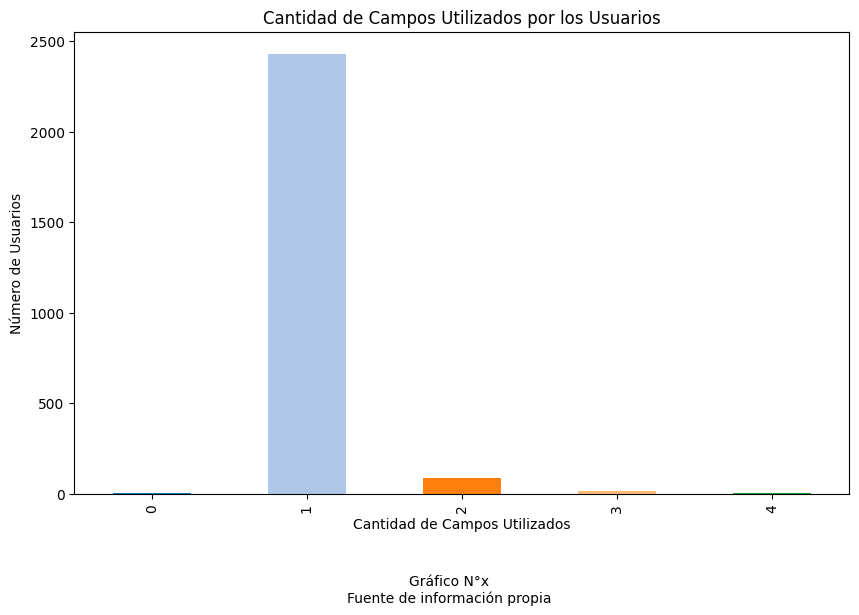

In [28]:
# Contamos la cantidad de veces que se utiliza cada cantidad de campos
cant_campos = df_filtrado['cant_campos_utilizados'].value_counts().sort_index()
print(cant_campos)

# Gráfico de barras para la cantidad de campos utilizados por los usuarios
plt.figure(figsize=(10, 6))
cant_campos.plot(kind='bar', color=plt.cm.tab20.colors)
plt.xlabel('Cantidad de Campos Utilizados')
plt.ylabel('Número de Usuarios')
plt.title('Cantidad de Campos Utilizados por los Usuarios')
plt.figtext(0.5, -0.05, 'Gráfico N°x\nFuente de información propia', ha='center', va='center')
plt.show()

##### Gráfico de barras para visualizar los campos de busqueda mas utilizados por los usuarios

kw          1808
au           255
mc-itype     206
ti           134
su            64
an            64
bc            64
su-to         30
callnum       23
l-format       5
se             3
not au         1
provider       1
in             1
Name: count, dtype: int64


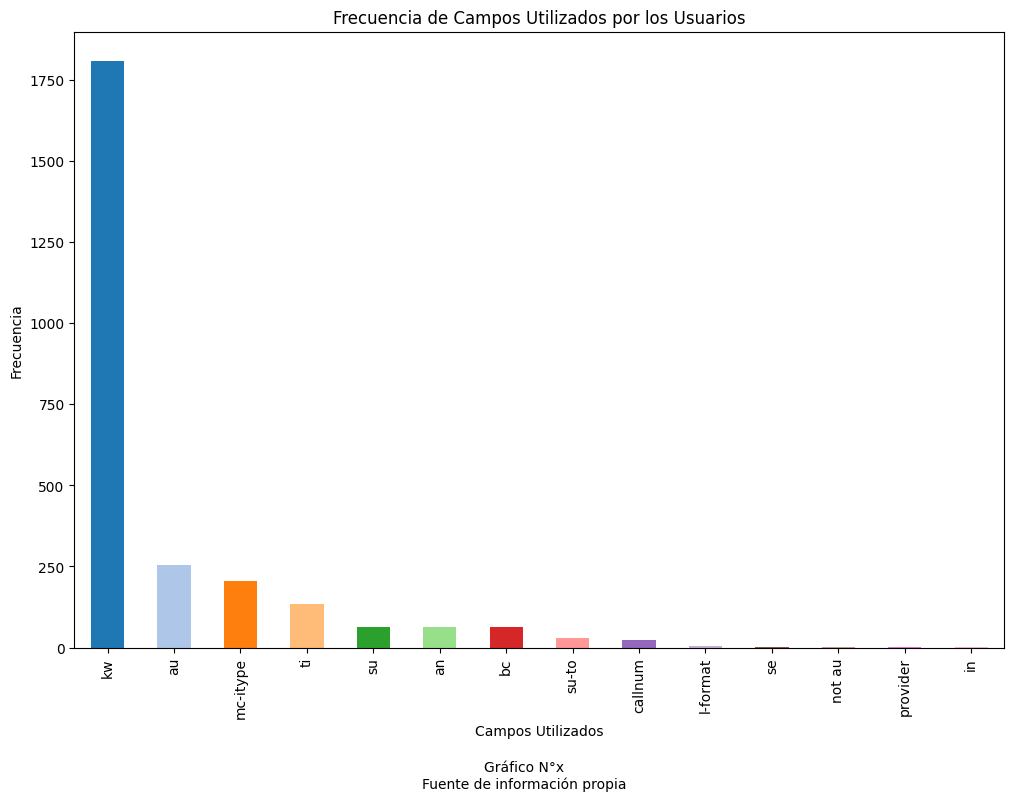

In [33]:
# Convertimos los campos a minúsculas y sumamos las frecuencias
frecuencia_campos = df_filtrado['campo_utilizado'].str.lower().str.split(', ', expand=True).stack().value_counts()
print(frecuencia_campos)

# Gráfico de las frecuencias de los campos utilizados por los usuarios
plt.figure(figsize=(12, 8))
frecuencia_campos.plot(kind='bar', color=plt.cm.tab20.colors)
plt.xlabel('Campos Utilizados')
plt.ylabel('Frecuencia')
plt.title('Frecuencia de Campos Utilizados por los Usuarios')
plt.figtext(0.5, -0.05, 'Gráfico N°x\nFuente de información propia', ha='center', va='center')
plt.show()

# Filtramos la serie para excluir el campo 'kw'
frecuencia_campos_sin_kw = frecuencia_campos.drop('kw')

##### Gráfico de barras para visualizar los campos de busqueda mas utilizados por los usuarios (sin el campo 'kw')

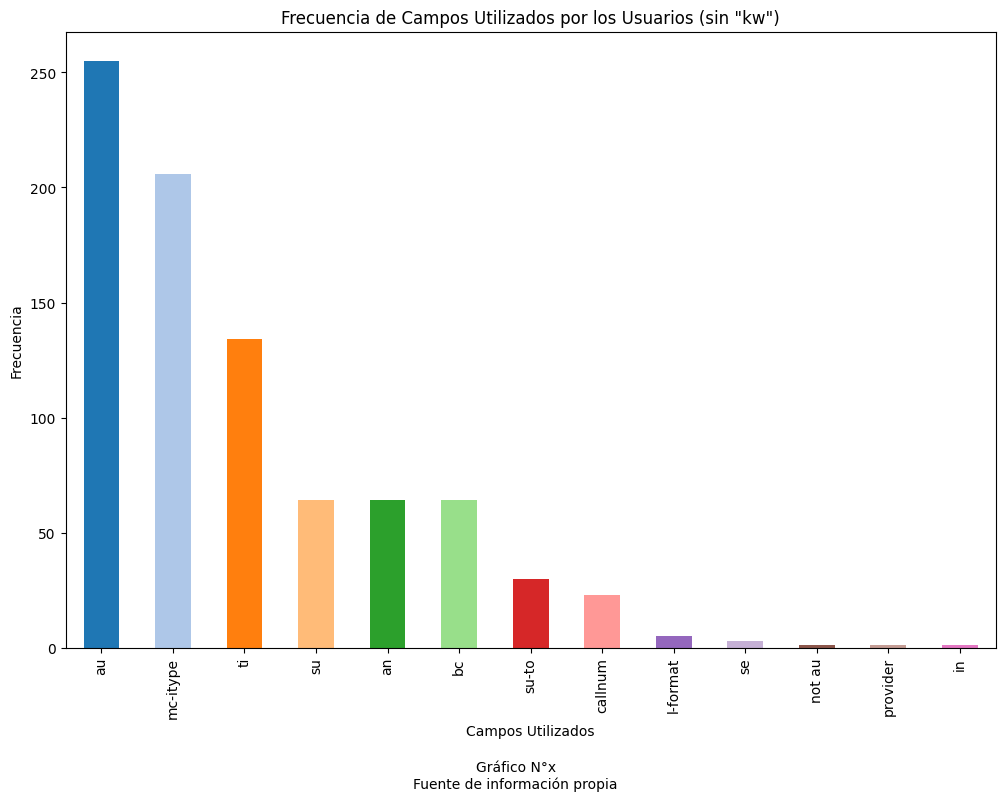

In [34]:
# Gráfico de las frecuencias de los campos utilizados por los usuarios sin 'kw'
plt.figure(figsize=(12, 8))
frecuencia_campos_sin_kw.plot(kind='bar', color=plt.cm.tab20.colors)
plt.xlabel('Campos Utilizados')
plt.ylabel('Frecuencia')
plt.title('Frecuencia de Campos Utilizados por los Usuarios (sin "kw")')
plt.figtext(0.5, -0.05, 'Gráfico N°x\nFuente de información propia', ha='center', va='center')
plt.show()

##### Tabla de frecuencias de las combinaciones de campos que utilizaron los usuarios

In [35]:
# Filtramos las filas con más de un campo utilizado
combinaciones_campos = df_filtrado[df_filtrado['cant_campos_utilizados'] > 1]

# Contamos las combinaciones de campos utilizados
combinaciones_frecuencia = combinaciones_campos['campo_utilizado'].value_counts()
combinaciones_frecuencia_df = combinaciones_frecuencia.reset_index()
combinaciones_frecuencia_df.columns = ['Combinacion de Campos', 'Frecuencia']

# Mostramos la tabla de frecuencia
print(combinaciones_frecuencia_df)

            Combinacion de Campos  Frecuencia
0                    kw, mc-itype          35
1                          kw, au          12
2                       kw, su-to           9
3       mc-itype, mc-itype, su-to           4
4                       au, su-to           3
5                 mc-itype, su-to           3
6              mc-itype, mc-itype           3
7                          ti, au           3
8              mc-itype, l-format           3
9                au, su-to, su-to           3
10                   mc-itype, au           3
11                   au, mc-itype           2
12               kw, kw, mc-itype           2
13                   su, mc-itype           2
14  mc-itype, mc-itype, su-to, au           1
15     au, ti, mc-itype, mc-itype           1
16               su, kw, mc-itype           1
17                     au, ti, in           1
18                   ti, mc-itype           1
19                         su, kw           1
20                         kw, se 

### Análisis de los datos que no obtuvieron resultados

##### Extraemos las sintaxis de los usuarios cuando el sistema no encuentra ningun resultado

In [37]:
# Filtramos las búsquedas que tengan como resultado cero
cero_resultados = df_filtrado[df_filtrado['total'] == 0].copy()

# Vemos cuántas búsquedas tienen cero resultados
print(len(cero_resultados))

# Aplicamos la función para extraer la sintaxis de las búsquedas que tienen cero resultados
cero_resultados.loc[:, 'sintaxis'] = cero_resultados['query_desc'].apply(extraer_sintaxis)

# Reordenamos las columnas
cero_resultados = cero_resultados[['sessionid', 'query_desc', 'total', 'time', 'categorycode', 'campo_utilizado', 'sintaxis', 'cant_campos_utilizados']]

317


In [38]:
# Guardamos el DataFrame con los resultados son iguales a cero en un archivo CSV (esto fue solicitado por la coordinadora)
cero_resultados.to_csv('1 - archivos/df_cero_resultados.csv', index=False)

In [39]:
# Aplicar la función al DataFrame 'cero_resultados' y crear una nueva columna 'error_campo'
cero_resultados['problema_detectado'] = cero_resultados.apply(verificar_error_campo, axis=1)

In [40]:
# Vemos cual es la falla en el/los campo/s utilizado/s en las búsquedas que tienen cero resultados
cero_resultados.loc[50, 'problema_detectado'] = (cero_resultados.loc[50, 'problema_detectado'] + 'no había resultados en el tiempo de la consulta')
cero_resultados.loc[2236, 'problema_detectado'] = (cero_resultados.loc[2236, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[2237, 'problema_detectado'] = (cero_resultados.loc[2237, 'problema_detectado'] + 'no hay resultados') 
cero_resultados.loc[47, 'problema_detectado'] = (cero_resultados.loc[47, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[874, 'problema_detectado'] = (cero_resultados.loc[874, 'problema_detectado'] + 'campo incorrecto')
cero_resultados.loc[1704, 'problema_detectado'] = (cero_resultados.loc[1704, 'problema_detectado'] + 'campo incorrecto')
cero_resultados.loc[1803, 'problema_detectado'] = (cero_resultados.loc[1803, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[873, 'problema_detectado'] = (cero_resultados.loc[873, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1804, 'problema_detectado'] = (cero_resultados.loc[1804, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1805, 'problema_detectado'] = (cero_resultados.loc[1805, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1806, 'problema_detectado'] = (cero_resultados.loc[1806, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1807, 'problema_detectado'] = (cero_resultados.loc[1807, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[129, 'problema_detectado'] = (cero_resultados.loc[129, 'problema_detectado'] + 'campo incorrecto')
cero_resultados.loc[130, 'problema_detectado'] = (cero_resultados.loc[130, 'problema_detectado'] + 'campo incorrecto')
cero_resultados.loc[1654, 'problema_detectado'] = (cero_resultados.loc[1654, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[131, 'problema_detectado'] = (cero_resultados.loc[131, 'problema_detectado'] + 'campo incorrecto')
cero_resultados.loc[450, 'problema_detectado'] = (cero_resultados.loc[450, 'problema_detectado'] + 'campo incorrecto')
cero_resultados.loc[449, 'problema_detectado'] = (cero_resultados.loc[449, 'problema_detectado'] + 'campo incorrecto')
cero_resultados.loc[446, 'problema_detectado'] = (cero_resultados.loc[446, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[2108, 'problema_detectado'] = (cero_resultados.loc[2108, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[408, 'problema_detectado'] = (cero_resultados.loc[408, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[2111, 'problema_detectado'] = (cero_resultados.loc[2111, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[241, 'problema_detectado'] = (cero_resultados.loc[241, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[242, 'problema_detectado'] = (cero_resultados.loc[242, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[386, 'problema_detectado'] = (cero_resultados.loc[386, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1588, 'problema_detectado'] = (cero_resultados.loc[1588, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[79, 'problema_detectado'] = (cero_resultados.loc[79, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[19, 'problema_detectado'] = (cero_resultados.loc[19, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[24, 'problema_detectado'] = (cero_resultados.loc[24, 'problema_detectado'] + 'campo incorrecto')
cero_resultados.loc[54, 'problema_detectado'] = (cero_resultados.loc[54, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[55, 'problema_detectado'] = (cero_resultados.loc[55, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[61, 'problema_detectado'] = (cero_resultados.loc[61, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[62, 'problema_detectado'] = (cero_resultados.loc[62, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[63, 'problema_detectado'] = (cero_resultados.loc[63, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[64, 'problema_detectado'] = (cero_resultados.loc[64, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[66, 'problema_detectado'] = (cero_resultados.loc[66, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[68, 'problema_detectado'] = (cero_resultados.loc[68, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[69, 'problema_detectado'] = (cero_resultados.loc[69, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[70, 'problema_detectado'] = (cero_resultados.loc[70, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[72, 'problema_detectado'] = (cero_resultados.loc[72, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[73, 'problema_detectado'] = (cero_resultados.loc[73, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[74, 'problema_detectado'] = (cero_resultados.loc[74, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[75, 'problema_detectado'] = (cero_resultados.loc[75, 'problema_detectado'] + 'campo incorrecto')
cero_resultados.loc[76, 'problema_detectado'] = (cero_resultados.loc[76, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[77, 'problema_detectado'] = (cero_resultados.loc[77, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[78, 'problema_detectado'] = (cero_resultados.loc[78, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[84, 'problema_detectado'] = (cero_resultados.loc[84, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[89, 'problema_detectado'] = (cero_resultados.loc[89, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[90, 'problema_detectado'] = (cero_resultados.loc[90, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[95, 'problema_detectado'] = (cero_resultados.loc[95, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[113, 'problema_detectado'] = (cero_resultados.loc[113, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[114, 'problema_detectado'] = (cero_resultados.loc[114, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[115, 'problema_detectado'] = (cero_resultados.loc[115, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[116, 'problema_detectado'] = (cero_resultados.loc[116, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[117, 'problema_detectado'] = (cero_resultados.loc[117, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[118, 'problema_detectado'] = (cero_resultados.loc[118, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[128, 'problema_detectado'] = (cero_resultados.loc[128, 'problema_detectado'] + 'campo incorrecto')
cero_resultados.loc[138, 'problema_detectado'] = (cero_resultados.loc[138, 'problema_detectado'] + 'no había resultados en el tiempo de la consulta')
cero_resultados.loc[140, 'problema_detectado'] = (cero_resultados.loc[140, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[151, 'problema_detectado'] = (cero_resultados.loc[151, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[158, 'problema_detectado'] = (cero_resultados.loc[158, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[159, 'problema_detectado'] = (cero_resultados.loc[159, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[185, 'problema_detectado'] = (cero_resultados.loc[185, 'problema_detectado'] + 'no había resultados en el tiempo de la consulta')
cero_resultados.loc[219, 'problema_detectado'] = (cero_resultados.loc[219, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[220, 'problema_detectado'] = (cero_resultados.loc[220, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[221, 'problema_detectado'] = (cero_resultados.loc[221, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[222, 'problema_detectado'] = (cero_resultados.loc[222, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[243, 'problema_detectado'] = (cero_resultados.loc[243, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[271, 'problema_detectado'] = (cero_resultados.loc[271, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[274, 'problema_detectado'] = (cero_resultados.loc[274, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[278, 'problema_detectado'] = (cero_resultados.loc[278, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[293, 'problema_detectado'] = (cero_resultados.loc[293, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[294, 'problema_detectado'] = (cero_resultados.loc[294, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[298, 'problema_detectado'] = (cero_resultados.loc[298, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[323, 'problema_detectado'] = (cero_resultados.loc[323, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[327, 'problema_detectado'] = (cero_resultados.loc[327, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[339, 'problema_detectado'] = (cero_resultados.loc[339, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[346, 'problema_detectado'] = (cero_resultados.loc[346, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[371, 'problema_detectado'] = (cero_resultados.loc[371, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[372, 'problema_detectado'] = (cero_resultados.loc[372, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[389, 'problema_detectado'] = (cero_resultados.loc[389, 'problema_detectado'] + 'campo incorrecto')
cero_resultados.loc[390, 'problema_detectado'] = (cero_resultados.loc[390, 'problema_detectado'] + 'campo incorrecto')
cero_resultados.loc[402, 'problema_detectado'] = (cero_resultados.loc[402, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[415, 'problema_detectado'] = (cero_resultados.loc[415, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[483, 'problema_detectado'] = (cero_resultados.loc[483, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[484, 'problema_detectado'] = (cero_resultados.loc[484, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[485, 'problema_detectado'] = (cero_resultados.loc[485, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[493, 'problema_detectado'] = (cero_resultados.loc[493, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[495, 'problema_detectado'] = (cero_resultados.loc[495, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[498, 'problema_detectado'] = (cero_resultados.loc[498, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[512, 'problema_detectado'] = (cero_resultados.loc[512, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[513, 'problema_detectado'] = (cero_resultados.loc[513, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[520, 'problema_detectado'] = (cero_resultados.loc[520, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[522, 'problema_detectado'] = (cero_resultados.loc[522, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[535, 'problema_detectado'] = (cero_resultados.loc[535, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[552, 'problema_detectado'] = (cero_resultados.loc[552, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[583, 'problema_detectado'] = (cero_resultados.loc[583, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[586, 'problema_detectado'] = (cero_resultados.loc[586, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[592, 'problema_detectado'] = (cero_resultados.loc[592, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[655, 'problema_detectado'] = (cero_resultados.loc[655, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[699, 'problema_detectado'] = (cero_resultados.loc[699, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[738, 'problema_detectado'] = (cero_resultados.loc[738, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[754, 'problema_detectado'] = (cero_resultados.loc[754, 'problema_detectado'] + 'no había resultados en el tiempo de la consulta')
cero_resultados.loc[766, 'problema_detectado'] = (cero_resultados.loc[766, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[770, 'problema_detectado'] = (cero_resultados.loc[770, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[771, 'problema_detectado'] = (cero_resultados.loc[771, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[776, 'problema_detectado'] = (cero_resultados.loc[776, 'problema_detectado'] + 'combinacion de campos incorrecta')
cero_resultados.loc[793, 'problema_detectado'] = (cero_resultados.loc[793, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[802, 'problema_detectado'] = (cero_resultados.loc[802, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[809, 'problema_detectado'] = (cero_resultados.loc[809, 'problema_detectado'] + 'campo incorrecto')
cero_resultados.loc[810, 'problema_detectado'] = (cero_resultados.loc[810, 'problema_detectado'] + 'no había resultados en el tiempo de la consulta')
cero_resultados.loc[816, 'problema_detectado'] = (cero_resultados.loc[816, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[817, 'problema_detectado'] = (cero_resultados.loc[817, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[820, 'problema_detectado'] = (cero_resultados.loc[820, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[837, 'problema_detectado'] = (cero_resultados.loc[837, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[839, 'problema_detectado'] = (cero_resultados.loc[839, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[843, 'problema_detectado'] = (cero_resultados.loc[843, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[848, 'problema_detectado'] = (cero_resultados.loc[848, 'problema_detectado'] + 'campo incorrecto')
cero_resultados.loc[852, 'problema_detectado'] = (cero_resultados.loc[852, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[865, 'problema_detectado'] = (cero_resultados.loc[865, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[871, 'problema_detectado'] = (cero_resultados.loc[871, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[872, 'problema_detectado'] = (cero_resultados.loc[872, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[885, 'problema_detectado'] = (cero_resultados.loc[885, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[891, 'problema_detectado'] = (cero_resultados.loc[891, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[892, 'problema_detectado'] = (cero_resultados.loc[892, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[894, 'problema_detectado'] = (cero_resultados.loc[894, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[895, 'problema_detectado'] = (cero_resultados.loc[895, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[897, 'problema_detectado'] = (cero_resultados.loc[897, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[938, 'problema_detectado'] = (cero_resultados.loc[938, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[939, 'problema_detectado'] = (cero_resultados.loc[939, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[944, 'problema_detectado'] = (cero_resultados.loc[944, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[946, 'problema_detectado'] = (cero_resultados.loc[946, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[981, 'problema_detectado'] = (cero_resultados.loc[981, 'problema_detectado'] + 'no había resultados en el tiempo de la consulta')
cero_resultados.loc[982, 'problema_detectado'] = (cero_resultados.loc[982, 'problema_detectado'] + 'no había resultados en el tiempo de la consulta')
cero_resultados.loc[983, 'problema_detectado'] = (cero_resultados.loc[983, 'problema_detectado'] + 'no había resultados en el tiempo de la consulta')
cero_resultados.loc[986, 'problema_detectado'] = (cero_resultados.loc[986, 'problema_detectado'] + 'no había resultados en el tiempo de la consulta')
cero_resultados.loc[987, 'problema_detectado'] = (cero_resultados.loc[987, 'problema_detectado'] + 'no había resultados en el tiempo de la consulta')
cero_resultados.loc[1001, 'problema_detectado'] = (cero_resultados.loc[1001, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[1006, 'problema_detectado'] = (cero_resultados.loc[1006, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1023, 'problema_detectado'] = (cero_resultados.loc[1023, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1024, 'problema_detectado'] = (cero_resultados.loc[1024, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1025, 'problema_detectado'] = (cero_resultados.loc[1025, 'problema_detectado'] + 'campo incorrecto')
cero_resultados.loc[1055, 'problema_detectado'] = (cero_resultados.loc[1055, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[1075, 'problema_detectado'] = (cero_resultados.loc[1075, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1076, 'problema_detectado'] = (cero_resultados.loc[1076, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1086, 'problema_detectado'] = (cero_resultados.loc[1086, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1087, 'problema_detectado'] = (cero_resultados.loc[1087, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1088, 'problema_detectado'] = (cero_resultados.loc[1088, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1143, 'problema_detectado'] = (cero_resultados.loc[1143, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1145, 'problema_detectado'] = (cero_resultados.loc[1145, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[1146, 'problema_detectado'] = (cero_resultados.loc[1146, 'problema_detectado'] + 'no había resultados en el tiempo de la consulta')
cero_resultados.loc[1147, 'problema_detectado'] = (cero_resultados.loc[1147, 'problema_detectado'] + 'no había resultados en el tiempo de la consulta')
cero_resultados.loc[1150, 'problema_detectado'] = (cero_resultados.loc[1150, 'problema_detectado'] + 'no había resultados en el tiempo de la consulta')
cero_resultados.loc[1151, 'problema_detectado'] = (cero_resultados.loc[1151, 'problema_detectado'] + 'no había resultados en el tiempo de la consulta')
cero_resultados.loc[1152, 'problema_detectado'] = (cero_resultados.loc[1152, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[1153, 'problema_detectado'] = (cero_resultados.loc[1153, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[1154, 'problema_detectado'] = (cero_resultados.loc[1154, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[1155, 'problema_detectado'] = (cero_resultados.loc[1155, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[1188, 'problema_detectado'] = (cero_resultados.loc[1188, 'problema_detectado'] + 'combinacion de campos incorrecta')
cero_resultados.loc[1189, 'problema_detectado'] = (cero_resultados.loc[1189, 'problema_detectado'] + 'combinacion de campos incorrecta')
cero_resultados.loc[1207, 'problema_detectado'] = (cero_resultados.loc[1207, 'problema_detectado'] + 'campo incorrecto')
cero_resultados.loc[1208, 'problema_detectado'] = (cero_resultados.loc[1208, 'problema_detectado'] + 'campo incorrecto')
cero_resultados.loc[1227, 'problema_detectado'] = (cero_resultados.loc[1227, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1234, 'problema_detectado'] = (cero_resultados.loc[1234, 'problema_detectado'] + 'no había resultados en el tiempo de la consulta')
cero_resultados.loc[1235, 'problema_detectado'] = (cero_resultados.loc[1235, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1238, 'problema_detectado'] = (cero_resultados.loc[1238, 'problema_detectado'] + 'no había resultados en el tiempo de la consulta')
cero_resultados.loc[1239, 'problema_detectado'] = (cero_resultados.loc[1239, 'problema_detectado'] + 'no había resultados en el tiempo de la consulta')
cero_resultados.loc[1253, 'problema_detectado'] = (cero_resultados.loc[1253, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[1258, 'problema_detectado'] = (cero_resultados.loc[1258, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1270, 'problema_detectado'] = (cero_resultados.loc[1270, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[1278, 'problema_detectado'] = (cero_resultados.loc[1278, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1281, 'problema_detectado'] = (cero_resultados.loc[1281, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[1286, 'problema_detectado'] = (cero_resultados.loc[1286, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[1292, 'problema_detectado'] = (cero_resultados.loc[1292, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1301, 'problema_detectado'] = (cero_resultados.loc[1301, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[1302, 'problema_detectado'] = (cero_resultados.loc[1302, 'problema_detectado'] + 'combinacion de campos incorrecta')
cero_resultados.loc[1303, 'problema_detectado'] = (cero_resultados.loc[1303, 'problema_detectado'] + 'combinacion de campos incorrecta')
cero_resultados.loc[1312, 'problema_detectado'] = (cero_resultados.loc[1312, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1332, 'problema_detectado'] = (cero_resultados.loc[1332, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1333, 'problema_detectado'] = (cero_resultados.loc[1333, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1334, 'problema_detectado'] = (cero_resultados.loc[1334, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1343, 'problema_detectado'] = (cero_resultados.loc[1343, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1344, 'problema_detectado'] = (cero_resultados.loc[1344, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1345, 'problema_detectado'] = (cero_resultados.loc[1345, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1346, 'problema_detectado'] = (cero_resultados.loc[1346, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1361, 'problema_detectado'] = (cero_resultados.loc[1361, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[1411, 'problema_detectado'] = (cero_resultados.loc[1411, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1435, 'problema_detectado'] = (cero_resultados.loc[1435, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1442, 'problema_detectado'] = (cero_resultados.loc[1442, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1448, 'problema_detectado'] = (cero_resultados.loc[1448, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1455, 'problema_detectado'] = (cero_resultados.loc[1455, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1480, 'problema_detectado'] = (cero_resultados.loc[1480, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1483, 'problema_detectado'] = (cero_resultados.loc[1483, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1506, 'problema_detectado'] = (cero_resultados.loc[1506, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[1507, 'problema_detectado'] = (cero_resultados.loc[1507, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[1532, 'problema_detectado'] = (cero_resultados.loc[1532, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1550, 'problema_detectado'] = (cero_resultados.loc[1550, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1556, 'problema_detectado'] = (cero_resultados.loc[1556, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1566, 'problema_detectado'] = (cero_resultados.loc[1566, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1587, 'problema_detectado'] = (cero_resultados.loc[1587, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1596, 'problema_detectado'] = (cero_resultados.loc[1596, 'problema_detectado'] + 'combinacion de campos incorrecta')
cero_resultados.loc[1614, 'problema_detectado'] = (cero_resultados.loc[1614, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[1656, 'problema_detectado'] = (cero_resultados.loc[1656, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1664, 'problema_detectado'] = (cero_resultados.loc[1664, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[1665, 'problema_detectado'] = (cero_resultados.loc[1665, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[1673, 'problema_detectado'] = (cero_resultados.loc[1673, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[1682, 'problema_detectado'] = (cero_resultados.loc[1682, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1684, 'problema_detectado'] = (cero_resultados.loc[1684, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1724, 'problema_detectado'] = (cero_resultados.loc[1724, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1727, 'problema_detectado'] = (cero_resultados.loc[1727, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1752, 'problema_detectado'] = (cero_resultados.loc[1752, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1822, 'problema_detectado'] = (cero_resultados.loc[1822, 'problema_detectado'] + 'lugar incorrecto de consulta')
cero_resultados.loc[1823, 'problema_detectado'] = (cero_resultados.loc[1823, 'problema_detectado'] + 'lugar incorrecto de consulta')
cero_resultados.loc[1825, 'problema_detectado'] = (cero_resultados.loc[1825, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1826, 'problema_detectado'] = (cero_resultados.loc[1826, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1829, 'problema_detectado'] = (cero_resultados.loc[1829, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[1835, 'problema_detectado'] = (cero_resultados.loc[1835, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[1843, 'problema_detectado'] = (cero_resultados.loc[1843, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1847, 'problema_detectado'] = (cero_resultados.loc[1847, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[1883, 'problema_detectado'] = (cero_resultados.loc[1883, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[1888, 'problema_detectado'] = (cero_resultados.loc[1888, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1897, 'problema_detectado'] = (cero_resultados.loc[1897, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1898, 'problema_detectado'] = (cero_resultados.loc[1898, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1899, 'problema_detectado'] = (cero_resultados.loc[1899, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1900, 'problema_detectado'] = (cero_resultados.loc[1900, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1951, 'problema_detectado'] = (cero_resultados.loc[1951, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1954, 'problema_detectado'] = (cero_resultados.loc[1954, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1955, 'problema_detectado'] = (cero_resultados.loc[1955, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[1986, 'problema_detectado'] = (cero_resultados.loc[1986, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[2015, 'problema_detectado'] = (cero_resultados.loc[2015, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[2017, 'problema_detectado'] = (cero_resultados.loc[2017, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[2019, 'problema_detectado'] = (cero_resultados.loc[2019, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[2020, 'problema_detectado'] = (cero_resultados.loc[2020, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[2024, 'problema_detectado'] = (cero_resultados.loc[2024, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[2030, 'problema_detectado'] = (cero_resultados.loc[2030, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[2043, 'problema_detectado'] = (cero_resultados.loc[2043, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[2049, 'problema_detectado'] = (cero_resultados.loc[2049, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[2051, 'problema_detectado'] = (cero_resultados.loc[2051, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[2058, 'problema_detectado'] = (cero_resultados.loc[2058, 'problema_detectado'] + 'lugar incorrecto de consulta')
cero_resultados.loc[2078, 'problema_detectado'] = (cero_resultados.loc[2078, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[2086, 'problema_detectado'] = (cero_resultados.loc[2086, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[2088, 'problema_detectado'] = (cero_resultados.loc[2088, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[2110, 'problema_detectado'] = (cero_resultados.loc[2110, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[2138, 'problema_detectado'] = (cero_resultados.loc[2138, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[2167, 'problema_detectado'] = (cero_resultados.loc[2167, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[2168, 'problema_detectado'] = (cero_resultados.loc[2168, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[2169, 'problema_detectado'] = (cero_resultados.loc[2169, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[2177, 'problema_detectado'] = (cero_resultados.loc[2177, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[2180, 'problema_detectado'] = (cero_resultados.loc[2180, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[2183, 'problema_detectado'] = (cero_resultados.loc[2183, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[2185, 'problema_detectado'] = (cero_resultados.loc[2185, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[2189, 'problema_detectado'] = (cero_resultados.loc[2189, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[2194, 'problema_detectado'] = (cero_resultados.loc[2194, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[2195, 'problema_detectado'] = (cero_resultados.loc[2195, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[2223, 'problema_detectado'] = (cero_resultados.loc[2223, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[2268, 'problema_detectado'] = (cero_resultados.loc[2268, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[2286, 'problema_detectado'] = (cero_resultados.loc[2286, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[2287, 'problema_detectado'] = (cero_resultados.loc[2287, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[2288, 'problema_detectado'] = (cero_resultados.loc[2288, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[2289, 'problema_detectado'] = (cero_resultados.loc[2289, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[2290, 'problema_detectado'] = (cero_resultados.loc[2290, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[2291, 'problema_detectado'] = (cero_resultados.loc[2291, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[2324, 'problema_detectado'] = (cero_resultados.loc[2324, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[2326, 'problema_detectado'] = (cero_resultados.loc[2326, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[2328, 'problema_detectado'] = (cero_resultados.loc[2328, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[2329, 'problema_detectado'] = (cero_resultados.loc[2329, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[2334, 'problema_detectado'] = (cero_resultados.loc[2334, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[2353, 'problema_detectado'] = (cero_resultados.loc[2353, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[2355, 'problema_detectado'] = (cero_resultados.loc[2355, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[2375, 'problema_detectado'] = (cero_resultados.loc[2375, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[2385, 'problema_detectado'] = (cero_resultados.loc[2385, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[2399, 'problema_detectado'] = (cero_resultados.loc[2399, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[2448, 'problema_detectado'] = (cero_resultados.loc[2448, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[2449, 'problema_detectado'] = (cero_resultados.loc[2449, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[2450, 'problema_detectado'] = (cero_resultados.loc[2450, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[2451, 'problema_detectado'] = (cero_resultados.loc[2451, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[2454, 'problema_detectado'] = (cero_resultados.loc[2454, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[2459, 'problema_detectado'] = (cero_resultados.loc[2459, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[2460, 'problema_detectado'] = (cero_resultados.loc[2460, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[2470, 'problema_detectado'] = (cero_resultados.loc[2470, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[2471, 'problema_detectado'] = (cero_resultados.loc[2471, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[2475, 'problema_detectado'] = (cero_resultados.loc[2475, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[2480, 'problema_detectado'] = (cero_resultados.loc[2480, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[2484, 'problema_detectado'] = (cero_resultados.loc[2484, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[2486, 'problema_detectado'] = (cero_resultados.loc[2486, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[2493, 'problema_detectado'] = (cero_resultados.loc[2493, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[2494, 'problema_detectado'] = (cero_resultados.loc[2494, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[2495, 'problema_detectado'] = (cero_resultados.loc[2495, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[2506, 'problema_detectado'] = (cero_resultados.loc[2506, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[2507, 'problema_detectado'] = (cero_resultados.loc[2507, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[2508, 'problema_detectado'] = (cero_resultados.loc[2508, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[2512, 'problema_detectado'] = (cero_resultados.loc[2512, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[2531, 'problema_detectado'] = (cero_resultados.loc[2531, 'problema_detectado'] + 'error de tipeo')

In [41]:
# Guardamos el DataFrame resultante de las búsquedas con cero resultados, con los errores ya categorizados
cero_resultados.to_csv('1 - archivos/busquedas_cero_resultados.csv', index=False)

problema_detectado
error de tipeo                                     169
no hay resultados                                   81
campo incorrecto                                    40
no había resultados en el tiempo de la consulta     17
combinacion de campos incorrecta                     6
lugar incorrecto de consulta                         3
usuario no ingreso nada                              1
Name: count, dtype: int64


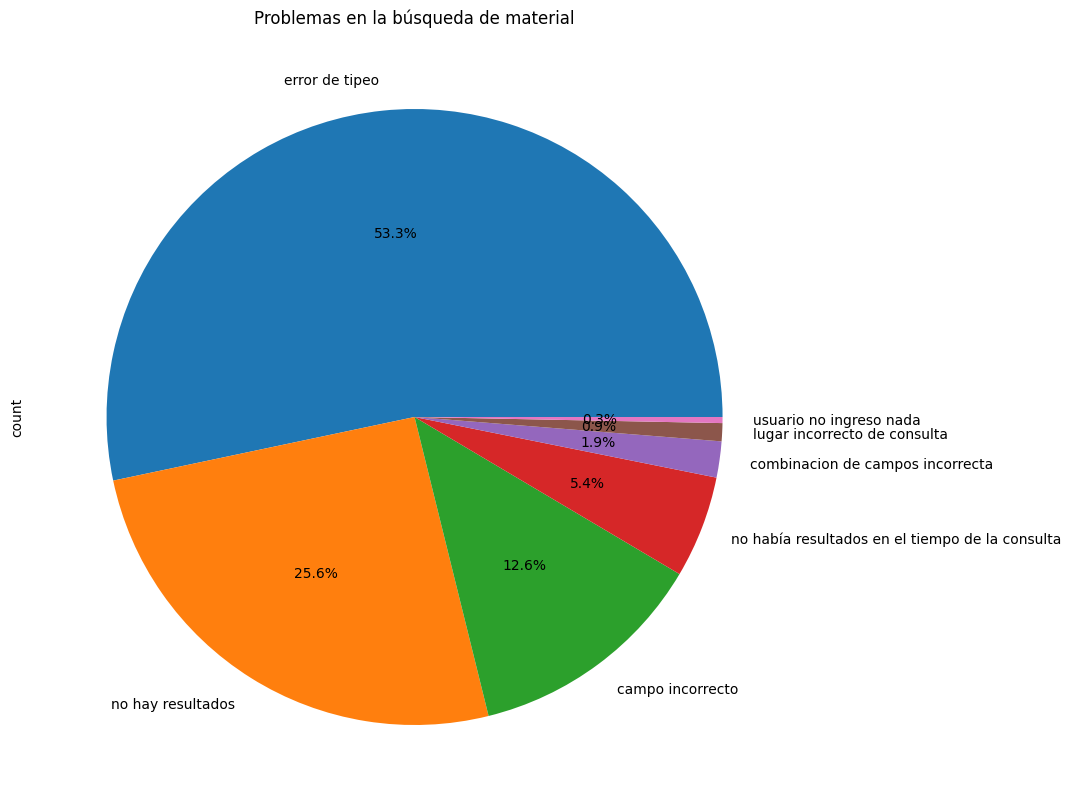

In [27]:
# Gráfico de torta para ver los porcentajes de las causas de los ceros en los resultados
print(cero_resultados['problema_detectado'].value_counts())
cero_resultados['problema_detectado'].value_counts().plot.pie(autopct='%1.1f%%', figsize=(10, 10))
plt.title('Problemas en la búsqueda de material')
plt.show()

### Análisis a los datos con al menos un resultado

In [28]:
# Filtramos las búsquedas que tengan al menos un resultado
busq_con_resultados = df_filtrado[df_filtrado['total'] > 0].copy()

# Vemos cuántas búsquedas tienen al menos un resultado
print(len(busq_con_resultados))

# Aplicamos la función para extraer la sintaxis de las búsquedas que tienen al menos un resultado
busq_con_resultados.loc[:, 'sintaxis'] = busq_con_resultados['query_desc'].apply(extraer_sintaxis)

# Reordenamos las columnas
busq_con_resultados = busq_con_resultados[['sessionid', 'query_desc', 'total', 'time', 'categorycode', 'campo_utilizado', 'sintaxis', 'cant_campos_utilizados']]

# Mostramos las primeras filas
busq_con_resultados.head()

2218


,sessionid,query_desc,total,time,categorycode,campo_utilizado,sintaxis,cant_campos_utilizados
0,8b973f78de404b6eb6548e4a229cb725,"au,wrdl: bronzino",16,2018-10-17 15:27:49,DOCENTE,au,bronzino,1
1,8b973f78de404b6eb6548e4a229cb725,"au,wrdl: bronzino",16,2018-10-17 15:28:25,DOCENTE,au,bronzino,1
2,8b973f78de404b6eb6548e4a229cb725,"au,wrdl: webster",10,2018-10-17 15:29:51,DOCENTE,au,webster,1
3,8b973f78de404b6eb6548e4a229cb725,"au,wrdl: webster",10,2018-10-17 15:30:02,DOCENTE,au,webster,1
4,8b973f78de404b6eb6548e4a229cb725,"au,wrdl: webster",10,2018-10-17 15:30:13,DOCENTE,au,webster,1


In [29]:
# Queremos saber el porcentaje de búsquedas que tengan 10 o menos resultados
print(f"El porcentaje de busquedas que tengan 10 o menos resultados son: {round(len(busq_con_resultados[busq_con_resultados['total'] <= 10]) / len(busq_con_resultados)*100, 2)}%")

# Lo mismo, pero esta vez para las búsquedas que tengan 50 o menos resultados
print(f"El porcentaje de busquedas que tengan 50 o menos resultados son: {round(len(busq_con_resultados[busq_con_resultados['total'] <= 50]) / len(busq_con_resultados)*100, 2)}%")

# Lo mismo, pero ahora las busquedas con resultados mayores a 100
print(f"El porcentaje de busquedas que tengan 100 o mas resultados son: {round(len(busq_con_resultados[busq_con_resultados['total'] > 100]) / len(busq_con_resultados)*100, 2)}%")

El porcentaje de busquedas que tengan 10 o menos resultados son: 51.85%
El porcentaje de busquedas que tengan 50 o menos resultados son: 78.0%
El porcentaje de busquedas que tengan 100 o mas resultados son: 15.69%


kw          1595
au           210
mc-itype     197
ti           108
an            64
bc            63
su            56
su-to         30
l-format       5
se             2
not au         1
provider       1
in             1
Name: count, dtype: int64


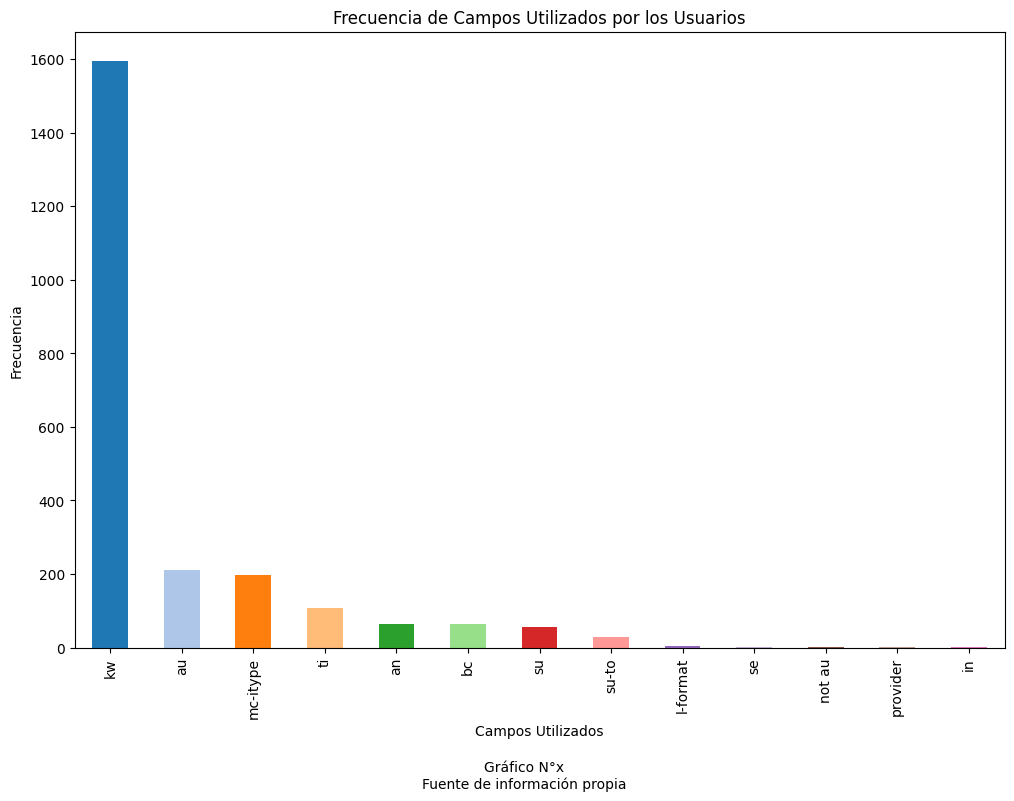

In [30]:
# Convertimos los campos a minúsculas y sumamos las frecuencias
frecuencia_campos = busq_con_resultados['campo_utilizado'].str.lower().str.split(', ', expand=True).stack().value_counts()
print(frecuencia_campos)

# Gráfico de las frecuencias de los campos utilizados por los usuarios
plt.figure(figsize=(12, 8))
frecuencia_campos.plot(kind='bar', color=plt.cm.tab20.colors)
plt.xlabel('Campos Utilizados')
plt.ylabel('Frecuencia')
plt.title('Frecuencia de Campos Utilizados por los Usuarios')
plt.figtext(0.5, -0.05, 'Gráfico N°x\nFuente de información propia', ha='center', va='center')
plt.show()

cant_campos_utilizados
1    2121
2      82
3      12
4       3
Name: count, dtype: int64


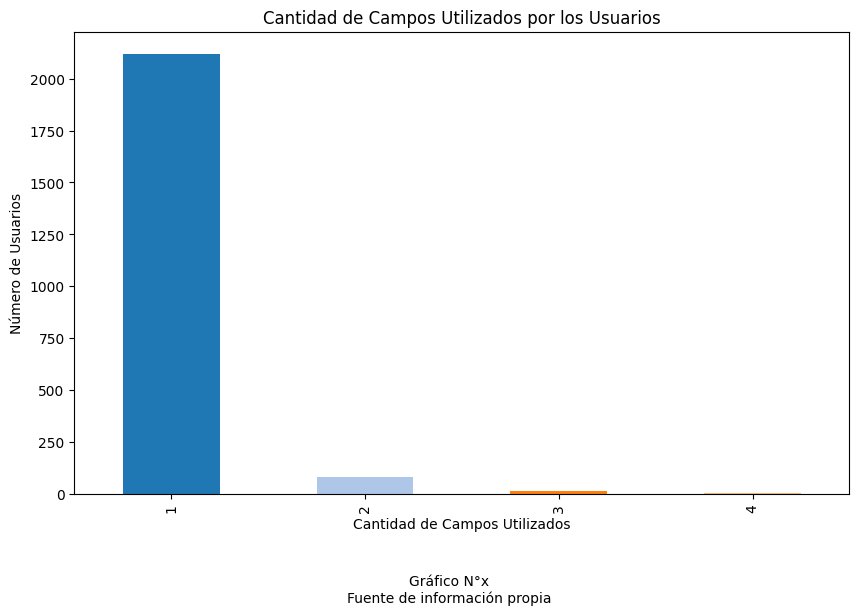

In [31]:
# Contamos la cantidad de veces que se utiliza cada cantidad de campos
cant_campos = busq_con_resultados['cant_campos_utilizados'].value_counts().sort_index()
print(cant_campos)

# Gráfico de barras para la cantidad de campos utilizados por los usuarios
plt.figure(figsize=(10, 6))
cant_campos.plot(kind='bar', color=plt.cm.tab20.colors)
plt.xlabel('Cantidad de Campos Utilizados')
plt.ylabel('Número de Usuarios')
plt.title('Cantidad de Campos Utilizados por los Usuarios')
plt.figtext(0.5, -0.05, 'Gráfico N°x\nFuente de información propia', ha='center', va='center')
plt.show()

In [32]:
# Vemos si al realizar la mismas consultas, el sistema devuelve la misma cantidad de resultados
# Identificar las consultas repetidas, agrupando por query_desc
consultas_repetidas = busq_con_resultados.groupby(['query_desc']).size().reset_index(name='repeticiones')
consultas_repetidas = consultas_repetidas[consultas_repetidas['repeticiones'] > 1]

# Filtrar las búsquedas repetidas
variacion_resultados = busq_con_resultados[busq_con_resultados['query_desc'].isin(consultas_repetidas['query_desc'])]
variacion_resultados = variacion_resultados.groupby(['query_desc'])['total'].agg(['mean', 'std', 'min', 'max']).reset_index()

# Si la desviación estándar es 0, significa que los resultados son iguales. Por eso nos vamos a quedar con aquellas consultas que tengan una desviación estándar mayor a 0
variacion_resultados = variacion_resultados[variacion_resultados['std'] > 0]

# Mostramos los resultados obtenidos 
variacion_resultados.head()

# Estos resultados son interesantes analizarlos en profundidad ya que nos puede dar información sobre la evolución de los registros a lo largo del tiempo.

,query_desc,mean,std,min,max
1,", mc-itype,phr:FICCION",268.500000,9.192388,262,275
3,", mc-itype:LIB",3654.966292,43.227319,3608,3777
5,", mc-itype:REV",168.571429,5.402482,154,176
6,", mc-itype:RL",118.000000,31.759513,92,163
7,", mc-itype:TE",44.000000,2.828427,42,46


### Comparación de las busquedas que utilizan un solo campos, con las busquedas que hacen una combinacion de campos

In [33]:
# Separamos las búsquedas que se realizaron con un solo campo y las que se realizaron con más de un campo
df_1campo = busq_con_resultados[busq_con_resultados['cant_campos_utilizados'] == 1].copy()
df_multi_campos = busq_con_resultados[busq_con_resultados['cant_campos_utilizados'] > 1].copy()

# El tamaño de cada dataframe
print(f"El tamaño del dataframe con búsquedas de un solo campo es: {len(df_1campo)}")
print(f"El tamaño del dataframe con búsquedas de más de un campo es: {len(df_multi_campos)}")

# Representando en porcentaje
print(f"El porcentaje de búsquedas de un solo campo es: {round(len(df_1campo) / len(busq_con_resultados)*100, 2)}%")
print(f"El porcentaje de búsquedas de más de un campo es: {round(len(df_multi_campos) / len(busq_con_resultados)*100, 2)}%")

# Vamos a ver si hay alguna diferencia en la cantidad de resultados obtenidos entre las búsquedas de un solo campo y las de más de un campo
print(f"El promedio de resultados obtenidos en las búsquedas de un solo campo es: {df_1campo['total'].mean()}")
print(f"El promedio de resultados obtenidos en las búsquedas de más de un campo es: {df_multi_campos['total'].mean()}")
print(f"El mínimo de resultados obtenidos en las búsquedas de un solo campo es: {df_1campo['total'].min()}")
print(f"El mínimo de resultados obtenidos en las búsquedas de más de un campo es: {df_multi_campos['total'].min()}")
print(f"El máximo de resultados obtenidos en las búsquedas de un solo campo es: {df_1campo['total'].max()}")
print(f"El máximo de resultados obtenidos en las búsquedas de más de un campo es: {df_multi_campos['total'].max()}")
print(f"La mediana de resultados obtenidos en las búsquedas de un solo campo es: {df_1campo['total'].median()}")
print(f"La mediana de resultados obtenidos en las búsquedas de más de un campo es: {df_multi_campos['total'].median()}")
# Notamos una gran diferencia en los resultados obtenidos entre las búsquedas de un solo campo y las de más de un campo.

El tamaño del dataframe con búsquedas de un solo campo es: 2121
El tamaño del dataframe con búsquedas de más de un campo es: 97
El porcentaje de búsquedas de un solo campo es: 95.63%
El porcentaje de búsquedas de más de un campo es: 4.37%
El promedio de resultados obtenidos en las búsquedas de un solo campo es: 223.3083451202263
El promedio de resultados obtenidos en las búsquedas de más de un campo es: 86.73195876288659
El mínimo de resultados obtenidos en las búsquedas de un solo campo es: 1
El mínimo de resultados obtenidos en las búsquedas de más de un campo es: 1
El máximo de resultados obtenidos en las búsquedas de un solo campo es: 11525
El máximo de resultados obtenidos en las búsquedas de más de un campo es: 3634
La mediana de resultados obtenidos en las búsquedas de un solo campo es: 10.0
La mediana de resultados obtenidos en las búsquedas de más de un campo es: 7.0


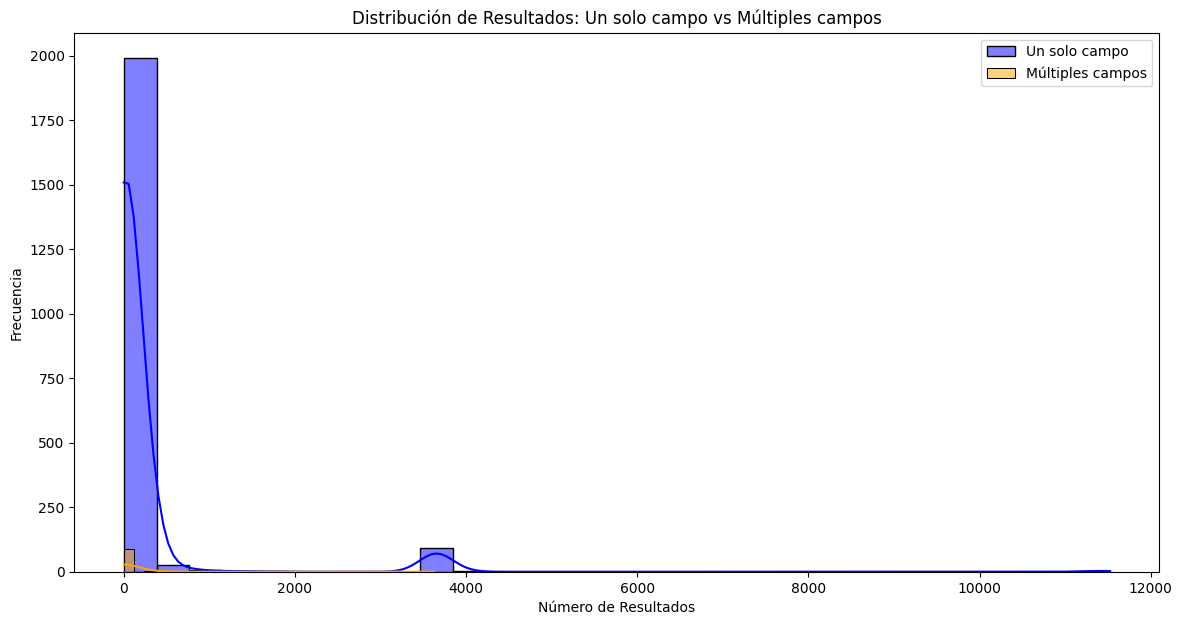

In [34]:
# Comparar la distribución de los resultados entre ambos dataframes
plt.figure(figsize=(14, 7))

# Distribución de resultados para búsquedas de un solo campo
sns.histplot(df_1campo['total'], kde=True, color='blue', label='Un solo campo', bins=30)

# Distribución de resultados para búsquedas de múltiples campos
sns.histplot(df_multi_campos['total'], kde=True, color='orange', label='Múltiples campos', bins=30)

plt.xlabel('Número de Resultados')
plt.ylabel('Frecuencia')
plt.title('Distribución de Resultados: Un solo campo vs Múltiples campos')
plt.legend()
plt.show()

### Análisis sobre las diferentes terminos de busqueda

In [49]:
terminos_busq = busq_con_resultados
terminos_busq.loc[:, 'sintaxis'] = terminos_busq['query_desc'].apply(extraer_sintaxis)

sintaxis
lib                         90
serway                      90
cooper                      74
prometheus                  43
cengel                      43
silverthorn                 34
lodish                      29
mezquita                    25
churchill                   21
ross                        21
stewart                     20
curtis                      19
tortora                     19
chang                       18
alberts                     18
boylestad                   15
rhoades                     15
rev                         14
tipler                      13
frumento                    13
zemansky                    12
latarjet                    12
kaplan                      11
cálculo                     11
calculo varias variables    10
garcia                      10
termodinamica               10
la celula                   10
grossman                     9
anatomia                     9
Name: count, dtype: int64


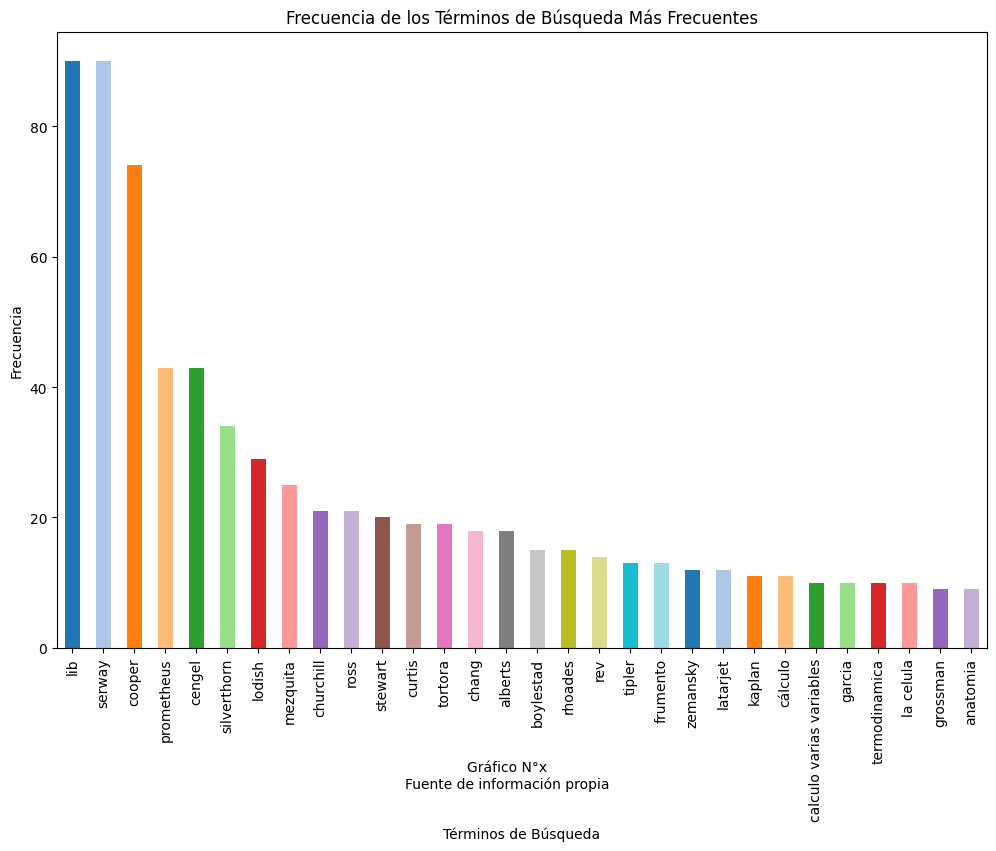

In [53]:
# Contar la frecuencia de cada término, posterior al pasado de los terminos a minusculas
frecuencia_terminos = terminos_busq['sintaxis'].str.lower().value_counts()

# Mostrar los términos más frecuentes
print(frecuencia_terminos.head(30))

# Graficar la frecuencia de los términos más frecuentes
plt.figure(figsize=(12, 8))
frecuencia_terminos.head(30).plot(kind='bar', color=plt.cm.tab20.colors)
plt.xlabel('Términos de Búsqueda')
plt.ylabel('Frecuencia')
plt.title('Frecuencia de los Términos de Búsqueda Más Frecuentes')
plt.figtext(0.5, -0.05, 'Gráfico N°x\nFuente de información propia', ha='center', va='center')
plt.show()

In [55]:
# Calcular la tasa de respuesta
total_busquedas = len(df_filtrado)
busquedas_con_resultados = len(df_filtrado[df_filtrado['total'] > 0])
tasa_respuesta = busquedas_con_resultados / total_busquedas

print(f'Tasa de respuesta: {tasa_respuesta:.2%}')


Tasa de respuesta: 87.50%


In [65]:
# Calcular la tasa de respuesta por tipo de campo de busqueda utilizado
tasa_respuesta_por_termino = df_filtrado.groupby('campo_utilizado').apply(lambda x: len(x[x['total'] > 0]) / len(x)).reset_index(name='tasa_respuesta')

# Dividimos los porcentajes obtenidos 
tasa_resp1 = tasa_respuesta_por_termino[tasa_respuesta_por_termino['tasa_respuesta'] == 1]
tasa_resp0 = tasa_respuesta_por_termino[tasa_respuesta_por_termino['tasa_respuesta'] < 1]

# Vemos cuales campos tienen un porcentaje de respuestas menor a 1
tasa_resp0

C:\Users\Laura\AppData\Local\Temp\ipykernel_1196\2298327919.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tasa_respuesta_por_termino = df_filtrado.groupby('campo_utilizado').apply(lambda x: len(x[x['total'] > 0]) / len(x)).reset_index(name='tasa_respuesta')


,campo_utilizado,tasa_respuesta
1,au,0.805430
10,bc,0.984375
11,callnum,0.000000
12,kw,0.881239
14,"kw, kw, mc-itype",0.000000
15,"kw, mc-itype",0.971429
21,mc-itype,0.968992
30,se,0.500000
31,su,0.881356
32,"su, kw",0.000000


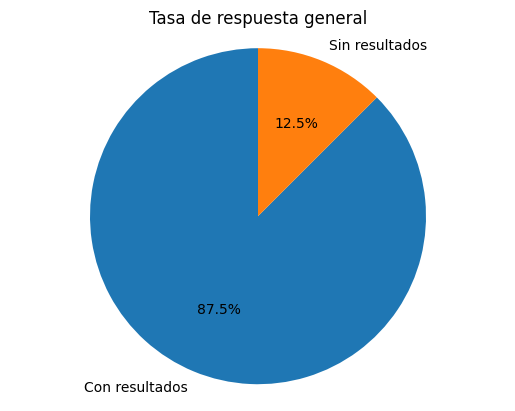

In [66]:
# Gráfico de pastel para la tasa de respuesta general
labels = ['Con resultados', 'Sin resultados']
sizes = [busquedas_con_resultados, total_busquedas - busquedas_con_resultados]
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Para que el gráfico sea un círculo
plt.title('Tasa de respuesta general')
plt.show()